<a href="https://colab.research.google.com/github/notrichardren/CIS522-homework/blob/main/assn3_insanity_debugging_nightmare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://en.wikipedia.org/wiki/Normal_distribution
def norm_logpdf(x, loc=0.0, scale=1.0):
    return -np.log(scale) - 0.5*np.log(2.0*np.pi)-0.5*(x-loc)**2/scale**2

# https://en.wikipedia.org/wiki/Gamma_distribution
def gamma_logpdf(x, shape=0.0, scale=1.0):
    return (shape-1.0)*np.log(x) - x/scale - lgamma(shape) - shape*np.log(scale)

# https://en.wikipedia.org/wiki/Inverse-gamma_distribution
def invgamma_logpdf(x, shape=0.0, scale=1.0):
    return shape*np.log(scale) - (shape+1.0)*np.log(x) - scale/x - lgamma(shape)

In [2]:
import jax.numpy as np
from jax import random
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
import jax.numpy as np
from jax import random, vmap, jit
from jax.lax import scan, cond
from functools import partial
from jax.experimental import host_callback
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from jax.lax import lgamma
from jax import jit, vmap
from jax.lax import scan, cond
from functools import partial

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

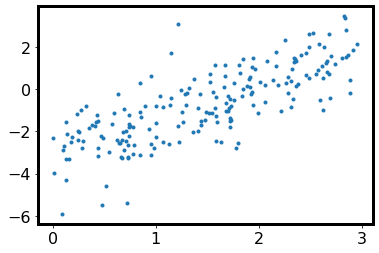

In [3]:
key = random.PRNGKey(0) # The answer to life, the universe, and everything.

# Define true parameters
alpha_true, beta_true, gamma_true = 1.5, -3.0, 1.0

# Generate training data D = (x, y) where N = 200
key, key2 = random.split(key)
x = random.uniform(key, (200,), minval = 0.0, maxval = 3.0)
epsilon_true = random.normal(key2, (200,))/np.sqrt(gamma_true)
y = alpha_true*x + beta_true + epsilon_true
plt.plot(x, y, ".")

In [4]:
# Posterior distribution
def log_prob(params):
    alpha, beta, gamma = params
    n = len(x)
    likelihood = np.log(np.sqrt(gamma / (2 * np.pi)) ** n) * np.exp((-gamma * np.sum((y - x * alpha - beta) ** 2)) / 2)
    prior_alpha = norm_logpdf(alpha, loc=0.0, scale=1.0) # mean=0, std1
    prior_beta = norm_logpdf(beta, loc=0.0, scale=1.0) # mean=0, std=1
    prior_gamma = gamma_logpdf(gamma, shape=2.0, scale=1.0)  # a=2, b=1
    return likelihood + prior_alpha + prior_beta + prior_gamma

def metropolis(log_prob, sigma):
    def init(rng_key, bounds):
        lb, ub = bounds
        dim = lb.shape[0]
        x0 = random.uniform(rng_key, (dim,), minval=lb, maxval=ub)
        return x0
    @partial(jit, static_argnums=(0,))
    def sample(num_samples, rng_key, init_state):
        def kernel(carry, i):
            key, state, logp = carry
            key, subkey = random.split(key)
            x = state + sigma * random.normal(subkey, state.shape)
            logp_prop = log_prob(x)
            u = random.uniform(key)
            cond = (u < np.exp(logp_prop - logp))
            state = np.where(cond, x, state)
            logp = np.where(cond, logp_prop, logp)
            return (key, state, logp), state
        logp = log_prob(init_state)
        _, samples = scan(kernel, (rng_key, init_state, logp), np.arange(num_samples))
        return samples
    return init, sample

In [5]:
# Define metropolis algorithm
step_size = 0.005
init_fn, sample_fn = metropolis(log_prob, step_size)

# Set bounds, numsteps
lb = np.array([-5.0, -5.0, -5.0])
ub = np.array([5.0, 5.0, 5.0])
burn_in = 2000
num_steps = 5000
init_state = init_fn(key, (lb, ub))

# Generate samples
samples = sample_fn(num_steps, key, init_state)[burn_in:,:]
samples_alpha = samples[:, 0]
samples_beta = samples[:, 1]
samples_gamma = samples[:, 2]

In [6]:
samples_alpha
#HOW
# WHY IS IT ALL THE SAME

Array([0.552479, 0.552479, 0.552479, ..., 0.552479, 0.552479, 0.552479],      dtype=float32)